In [1]:
import re

import numpy as np
from langchain_core.tools import tool
from langchain_community.embeddings import OllamaEmbeddings

with open('./docs/knowledge.txt','r') as f:
    faq_text = f.read()

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]



ollama_emb = OllamaEmbeddings(model="all-minilm", base_url='http://localhost:11434')


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list):
        self._arr = np.array(vectors)
        self._docs = docs

    @classmethod
    def from_docs(cls, docs, embedding_model):
        vectors = embedding_model.embed_documents([doc["page_content"] for doc in docs])
        return cls(docs, vectors)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = ollama_emb.embed_query(query)
        scores = np.array(embed) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs, ollama_emb)


@tool
def lookup_policy(query: str) -> str:
    """Consult documentation on tool usage"""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

In [2]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [4]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions, convert_to_ollama_tool
from libs.tool_def import get_metric_values, get_unique_dimension_values, get_available_columns
from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            # passenger_id = configuration.get("passenger_id", None)
            # state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            print("Assistent:",result)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

llm = OllamaFunctions(
    model="llama3", 
    base_url='http://localhost:11434',
    # base_url='https://c67e346f-66b5-4737-a492-0d1fc5b9c883.job.gra.ai.cloud.ovh.net',
    format='json')

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for interacting with database "
            " Use the provided tools to search inside the database "
            # " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            " If you have a response from a tool that answers the question, generate the final answer"
            # "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())



part_1_tools = [get_unique_dimension_values, get_metric_values, get_available_columns]

llm = llm.bind_tools(part_1_tools)
part_1_assistant_runnable = primary_assistant_prompt | llm #.with_structured_output(convert_to_ollama_tool(Response))

In [5]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    print('Last Message at Should continue', last_message)
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise we continue
    else:
        return "continue"
    
builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    # should_continue,
    # {
    #     "continue":"tools",
    #     "end": END
    # }
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

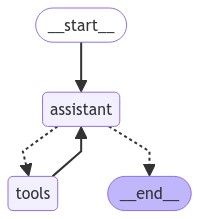

In [6]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
import uuid

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        # "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": str(uuid.uuid4()),
    },
    "recursion_limit": 5
}


_printed = set()
question = "get the average request_duration from the database"
# question = "get the unique protocol from the database"
events = part_1_graph.stream(
    {"messages": ("user", question)}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

get the average request_duration from the database
Assistent: content='' id='run-2a87e601-f78b-4141-a28f-98c326876a29-0' tool_calls=[{'name': 'get_metric_values', 'args': {'metric': 'request_duration', 'aggregation_type': 'avg', 'filter': {}}, 'id': 'call_f2ca3448863a4d038a818bc8f60aaae6', 'type': 'tool_call'}]
================================== Ai Message ==================================
Tool Calls:
  get_metric_values (call_f2ca3448863a4d038a818bc8f60aaae6)
 Call ID: call_f2ca3448863a4d038a818bc8f60aaae6
  Args:
    metric: request_duration
    aggregation_type: avg
    filter: {}
Running get_metric_values
SELECT avg(request_duration) FROM procedures 
================================= Tool Message =================================
Name: get_metric_values

{"response": 103.46403940886704}


ValueError: Failed to parse a response from llama3 output: {}